# Universidad Politécnica Salesiana
## Entrenamiento de una red neuronal Convolucional (2)
## Clasificación de perros y gatos
### Por Alexander Siavichay

Disponible en:https://github.com/siavichay/CNN/blob/master/CNN_desde_cero_Perros_y_Gatos_con_toolkit_Parte_2.ipynb

Antes de seguir, hecha un vistazo a la primera parte Clasificación de perros y gatos 
https://github.com/siavichay/CNN/blob/master/CNN_desde_cero_Perros_y_Gatos_con_toolkit_Parte_1.ipynb


En este apartado se realizan pruebas con un código escrito desde cero. Gracias a Mukul-Rathi, quien realizó el código con el dataset de prendas.

Se ha modificado el código para procesar el dataset de perros y gatos, un problema binario.

Primero se importan las librerías necesarias

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import ndimage 
from keras.datasets import mnist 
from tqdm import tqdm_notebook #used for progress bar - how far through training we are

Using TensorFlow backend.


## Procesamiento de datos
El primer método lo podríamos utilizar con datasets en Numpy arrays. En nuestro caso lo haremos utilizando ImageDataGenerator para no variar el análisis hecho en el libro anterior 

El dataset es el mismo utilizado en la primera parte, por lo tanto la estructura no cambiará


In [2]:
def process_input(X,Y):
    X = np.reshape(X,(X.shape[0], 28,28,1))
    X= X/255 #normalise input features 
    Y = np.eye(10)[Y.reshape(-1)].T #Y.reshape(-1) flattens the input to a 1D array
    #in general np.eye(num_classes)[array].T will take a 1D array with m training examples, and 
    #one-hot encode it into a (num_classes,m) matrix
    
    idx = np.random.permutation(np.arange(X.shape[0])) #shuffle indices
    
    X = X[idx]
    Y = Y[:,idx]
    return X,Y

#### Opcional
Podríamos utilizar datos en línea y obtener nuestro train y test.

In [180]:
(x_train_dev, y_train_dev), (x_test, y_test) = mnist.load_data()

x_train_dev, y_train_dev = process_input(x_train_dev, y_train_dev)

x_train, y_train = x_train_dev[:-10000], y_train_dev[:,:-10000]
x_dev, y_dev = x_train_dev[-10000:], y_train_dev[:,-10000:]

x_test , y_test = process_input(x_test , y_test)

In [181]:
print(y_train.shape)
print(y_train[0])

(10, 50000)
[0. 0. 0. ... 0. 0. 0.]


### Trtamiento de datos con ImageDataGenerator
Como habiamos explicado anteriormente, es necesario que el dataset tenga el mismo tratamiento que cuando se utilizó el Toolkit.

In [258]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
 shear_range = 0.2,
 zoom_range = 0.2,
 horizontal_flip = True)

training_set = train_datagen.flow_from_directory("dogscats/train",
 target_size = (28, 28),
 #batch_size = 23000,
    batch_size = 23000,
                                                 color_mode="grayscale",
 class_mode = "categorical")

Found 23000 images belonging to 2 classes.


In [259]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory("dogscats/valid",
 target_size = (28, 28),
 #batch_size = 2000,
  batch_size = 2000,
                                            color_mode="grayscale",
 class_mode = "categorical")

Found 2000 images belonging to 2 classes.


In [260]:
x_trainT, y_trainT = training_set.next()
x_devT, y_devT = test_set.next()


In [262]:
#Transponiendo las respuestas par acomodar al metodo
y_trainT=y_trainT.transpose()
y_devT=y_devT.transpose()


print(y_trainT.shape)
print(y_devT.shape)



(2, 23000)
(2, 2000)


In [263]:
print(y_trainT.shape[1])
rel=np.zeros((8,y_trainT.shape[1]),dtype=float)
y_trainT=np.vstack((y_trainT,rel))

rel=np.zeros((8,y_devT.shape[1]),dtype=float)
y_devT=np.vstack((y_devT,rel))

#y_devT=np.vstack((y_trainT,rel))
print(y_trainT.shape)
print(y_devT.shape)
print(ny.shape)

23000
(10, 23000)
(10, 2000)
(10, 1000)


In [42]:
print(x_dev.shape)

(2000, 64, 64, 3)


In [27]:
print(x_train.shape)

(50000, 28, 28, 1)


## Manos a la obra
Una vez que tenemos nuestro dataset listo, es hora de crear los métodos que habíamos utilizado en la primera parte con el toolkit, asi que, empezamos definiendolos a continuación:

Puesto que deseamos realizar una convolución en 2d, se realizan barridos en 2d a la entrada, luego, se suma, técnicamente una convolución matemática, se pasa el filtro  (i-a, j-b not i+a, j+b).

In [4]:
def conv_forward(x,w,b,padding="same"):
    if padding=="same": 
        pad = (w.shape[0]-1)//2
    else: #padding is valid - i.e no zero padding
        pad =0 
    n = (x.shape[1]-w.shape[0]+2*pad) +1 #ouput width/height
    
    y = np.zeros((x.shape[0],n,n,w.shape[3])) #output array
    
    #pad input
    x_padded = np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)),'constant', constant_values = 0)
    
    #flip filter to cancel out reflection
    w = np.flip(w,0)
    w = np.flip(w,1)
    
    f = w.shape[0] #size of filter
        
    for m_i in range(x.shape[0]): #each of the training examples
        for k in range(w.shape[3]): #each of the filters
            for d in range(x.shape[3]): #each slice of the input 
                y[m_i,:,:,k]+= ndimage.convolve(x_padded[m_i,:,:,d],w[:,:,d,k])[f//2:-(f//2),f//2:-(f//2)] #sum across depth
             
    y = y + b #add bias (this broadcasts across image)
    return y

En lo siguiente, se realiza un padding a la entrada de x, con ello se replica la entrada para regresar al pasado. Para optimizar este paso, se realiza una operción de expansión dW, se comuputa el producto punto de la matriz (m, i, j ,c, k), luego se la suma con las dimensiones (i, j).

In [5]:
def conv_backward(dZ,x,w,padding="same"):
    m = x.shape[0]
    
    db = (1/m)*np.sum(dZ, axis=(0,1,2), keepdims=True)
    
    if padding=="same": 
        pad = (w.shape[0]-1)//2
    else: #padding is valid - i.e no zero padding
        pad =0 
    x_padded = np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)),'constant', constant_values = 0)
    
    #this will allow us to broadcast operations
    x_padded_bcast = np.expand_dims(x_padded, axis=-1) # shape = (m, i, j, c, 1)
    dZ_bcast = np.expand_dims(dZ, axis=-2) # shape = (m, i, j, 1, k)
    
    dW = np.zeros_like(w)
    f=w.shape[0]
    w_x = x_padded.shape[1]
    for a in range(f):
        for b in range(f):
            #note f-1 - a rather than f-a since indexed from 0...f-1 not 1...f
            dW[a,b,:,:] = (1/m)*np.sum(dZ_bcast*x_padded_bcast[:,a:w_x-(f-1 -a),b:w_x-(f-1 -b),:,:],axis=(0,1,2))  
    
    dx = np.zeros_like(x_padded,dtype=float) 
    Z_pad = f-1
    dZ_padded = np.pad(dZ,((0,0),(Z_pad,Z_pad),(Z_pad,Z_pad),(0,0)),'constant', constant_values = 0)  
    
    for m_i in range(x.shape[0]):
        for k in range(w.shape[3]):
            for d in range(x.shape[3]):
                dx[m_i,:,:,d]+=ndimage.convolve(dZ_padded[m_i,:,:,k],w[:,:,d,k])[f//2:-(f//2),f//2:-(f//2)]
    dx = dx[:,pad:dx.shape[1]-pad,pad:dx.shape[2]-pad,:]
    return dx,dW,db

### Pooling
De igual manera que la convolución, se tienen a continuación los métodos para avanzar y retroceder.
En el avance (Forward), se computa el máximo y la media de cada patch, se redimensiona el arreglo para enmascarar el resultado a los gradientes. Luego para retornar se utiliza la misma máscara que enrutará el gradiente.



In [6]:
def pool_forward(x,mode="max"):
    x_patches = x.reshape(x.shape[0],x.shape[1]//2, 2,x.shape[2]//2, 2,x.shape[3])
    if mode=="max":
        out = x_patches.max(axis=2).max(axis=3)
        mask  =np.isclose(x,np.repeat(np.repeat(out,2,axis=1),2,axis=2)).astype(int)
    elif mode=="average": 
        out =  x_patches.mean(axis=3).mean(axis=4)
        mask = np.ones_like(x)*0.25
    return out,mask

In [7]:
def pool_backward(dx, mask):
    return mask*(np.repeat(np.repeat(dx,2,axis=1),2,axis=2))

### Conexión de todas las capas
Se utilizará la función de activación Relu para las capas ocultas, y al final la capa Softmax

In [8]:


def relu(x, deriv=False):
    if deriv:
        return (x>0)
    return np.multiply(x, x>0)



In [9]:
def fc_forward(x,w,b):
    return relu(w.dot(x)+b)

In [10]:
def softmax_forward(x,w,b):
    z = w.dot(x)+b
    z -= np.mean(z,axis=0,keepdims=True) #this ensures that the value exponentiated doesn't become too large and overflow
    a = np.exp(z) 
    a = a/np.sum(a,axis=0,keepdims=True)
    return a+1e-8 #add 1e-8 to ensure no 0 values - since log 0 is undefined

In [11]:
def fc_backward(dA,a,x,w,b):
    m = dA.shape[1]
    dZ = dA*relu(a,deriv=True)
    dW = (1/m)*dZ.dot(x.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dx =  np.dot(w.T,dZ)
    return dx, dW,db

In [12]:
def softmax_backward(y_pred, y, w, b, x):
    m = y.shape[1]
    dZ = y_pred - y
    dW = (1/m)*dZ.dot(x.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dx =  np.dot(w.T,dZ)
    return dx, dW,db

## Definición del modelo de red
Al igual que en la primera parte, se utilizará un pequeño modelo de red neuronal.
Por motivos de tiempo y procesamiento se utilizarán pocos filtros para reducir el entrenamiento.

Hemos utilizado un equipo con un procesador Intel Core I5 de tercera generación, 8ram.(Un poco pobre, para este tipo de trabajo, pero es lo que se dispone.)


In [13]:
def init_conv_parameters(f, n_c, k):
    
    return 0.5*np.random.normal(size=(f,f,n_c,k)), 0.15*np.ones((1,1,1,k))
                                                                      
def init_fc_parameters(n_x,n_y):
    return 0.1*np.random.normal(size=(n_y,n_x)),0.15+np.ones((n_y,1)) #slight positive bias to prevent dead ReLU

In [14]:
def initialise_parameters():    
    parameters={}
    parameters["W_conv1"], parameters["b_conv1"] = init_conv_parameters(5, 1, 4)
    parameters["W_conv2"], parameters["b_conv2"] = init_conv_parameters(5, 4, 4)

    parameters["W_conv3"], parameters["b_conv3"] = init_conv_parameters(3, 4, 8)
    parameters["W_conv4"], parameters["b_conv4"] = init_conv_parameters(3, 8,16)

    parameters["W_fc1"],parameters["b_fc1"] = init_fc_parameters(16*49,128)
    parameters["W_softmax"],parameters["b_softmax"] = init_fc_parameters(128,10)

    return parameters

### Forward propagation
Se realizará un propagación hacia adelante en toda la red. Aquí se almacenarán los valores en el caché para que sean utilizados en los cálculos posteriores.

In [15]:
def forward_prop(X,parameters):
    
    cache={}
    
    cache["z_conv1"] = conv_forward(X,parameters["W_conv1"], parameters["b_conv1"])
    cache["a_conv1"] = relu(cache["z_conv1"])

    cache["z_conv2"] = conv_forward(cache["a_conv1"],parameters["W_conv2"], parameters["b_conv2"])
    cache["a_conv2"] = relu(cache["z_conv2"])

    cache["z_pool1"], cache["mask_pool1"] = pool_forward(cache["a_conv2"])
    
 

    cache["z_conv3"] = conv_forward(cache["z_pool1"],parameters["W_conv3"], parameters["b_conv3"])
    cache["a_conv3"] = relu(cache["z_conv3"])
    
 

    cache["z_conv4"] = conv_forward(cache["a_conv3"],parameters["W_conv4"], parameters["b_conv4"] )
    cache["a_conv4"] = relu(cache["z_conv4"])
    
 
    cache["z_pool2"], cache["mask_pool2"] = pool_forward(cache["a_conv4"])


    cache["a_flatten"] = np.reshape(cache["z_pool2"], (cache["z_pool2"].shape[0],-1)).T

 
    cache["a_fc1"] = fc_forward( cache["a_flatten"],parameters["W_fc1"],parameters["b_fc1"])
    
    
    return softmax_forward(cache["a_fc1"],parameters["W_softmax"],parameters["b_softmax"]),cache

Loss function:
Para el cálculo del índice de pérdida se utilizará la función de regularización L2 (cross entropy)

In [192]:
def loss_function(y_pred,y,parameters,lambd):
    m = y.shape[1]
    cost = (-1/m)*np.sum(y*np.log(y_pred))
    
    regularisation_term = 0
    for key in parameters:
        if "W_" in key: #all the weights
            regularisation_term += np.sum(np.square(parameters[key]))
    
    regularised_cost = cost + (lambd/(2*m))*regularisation_term
    
    return regularised_cost

In [17]:
def backprop(X,Y,Y_pred,parameters,cache,lambd):
    grads = {}
    
    dA, grads["dW_softmax"],grads["db_softmax"] =softmax_backward(Y_pred, Y, parameters["W_softmax"],parameters["b_softmax"],cache["a_fc1"])

    dA, grads["dW_fc1"],grads["db_fc1"] = fc_backward(dA,cache["a_fc1"],cache["a_flatten"],parameters["W_fc1"],parameters["b_fc1"])
    
    dA = np.reshape(dA.T,cache["z_pool2"].shape)
    grads["dz_pool2"] = dA
    dA = pool_backward(dA, cache["mask_pool2"])
    
    dA = dA*relu(cache["z_conv4"],deriv=True)
    grads["dz_conv4"] = dA
    dA, grads["dW_conv4"],grads["db_conv4"] = conv_backward(dA,cache["a_conv3"],parameters["W_conv4"])
    
    dA = dA*relu(cache["z_conv3"],deriv=True)
    grads["dz_conv3"] = dA
    dA, grads["dW_conv3"],grads["db_conv3"] = conv_backward(dA,cache["z_pool1"],parameters["W_conv3"])
    
    grads["dz_pool1"] = dA
    dA = pool_backward(dA, cache["mask_pool1"])

    
    dA = dA*relu(cache["z_conv2"],deriv=True)
    grads["dz_conv2"] = dA
    dA, grads["dW_conv2"],grads["db_conv2"] = conv_backward(dA,cache["a_conv1"],parameters["W_conv2"])
    
    
    dA = dA*relu(cache["z_conv1"],deriv=True)
    grads["dz_conv1"] = dA
    grads["dx"], grads["dW_conv1"],grads["db_conv1"] = conv_backward(dA,X,parameters["W_conv1"])
    
    #regularisation term
    for key in grads:
        if "W" in key:
            grads[key]= grads[key]+ (lambd/X.shape[0])*parameters[key[1:]] 
    return grads

## Entrenamiento
Es importante que nuestro algoritmo pueda decirnos lo que está haciendo, por ello el código siguiente es más por motivos de aprendizaje y observación. Se enfocará por supuesto el accuracy entre las médidas más importantes.

In [18]:


def accuracy(y_pred,y):
    preds = np.argmax(y_pred,axis=0) #number with highest probability
    truth = np.argmax(y,axis=0) #correct label is 1 rest are 0 so this will get correct label
    return np.mean(np.equal(preds,truth).astype(int)) #check for each one if classified correctly,then take mean



In [19]:
def backprop_checker(parameters,grads, x, y,lambd):
    epsilon = 1e-7
    rel_threshold = 10
    num_sample = 10
    flag = True #if backprop is correct
    print("Checking gradients...")
    for param in reversed(list(parameters.keys())): #look at last layers first
        print("Checking: " + param)
        dims = parameters[param].shape
        
        
        num_grad = 0
        backprop_grad = 0
        
        for _ in range(num_sample): #sample 10 neurons
            idx = np.zeros(len(dims))
            for i in range(len(dims)):
                idx[i] = np.random.randint(0,dims[i])
            idx = tuple(idx.astype(int))

            parameters[param][idx]= parameters[param][idx] + epsilon
            y_pred_plus = forward_prop(x,parameters)[0]
            J_plus = loss_function(y_pred_plus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx] - 2*epsilon

            y_pred_minus = forward_prop(x,parameters)[0]

            J_minus = loss_function(y_pred_minus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx]+ epsilon

            num_grad += (J_plus-J_minus)/(2*epsilon)
            backprop_grad += grads["d"+param][idx]
            
            
        num_grad/=num_sample
        backprop_grad/=num_sample
        rel_error = abs((num_grad-backprop_grad)/num_grad)
        if rel_error>rel_threshold or num_grad==0:
            #print("J_plus: "+ str(J_plus))
            #print("J_minus: "+ str(J_minus))
            print("Numerical grad:" + str(num_grad))
            print("Backprop grad:" + str(backprop_grad))
            print("Relative error: " + str(rel_error))
            flag = False
            if(num_grad==0):
                print("DEAD RELU")
            else:
                print("Backprop calculation incorrect")
    print("Gradient check complete")
    assert(flag) #if not the backprop is massively out so kill training

In [20]:
def visualisation(X_train_minibatch,Y_train_minibatch,cache, minibatch_grads, parameters, y_pred):
    fig2, ax = plt.subplots(3,8)
    #plot the activations of an example in the minibatch throughout the forward pass   
    m_i =  np.random.randint(0,X_train_minibatch.shape[0]) #pick random sample
    
    #for simplicity we sample the first filter in the layer
    ax[0,0].imshow(X_train_minibatch[m_i,:,:,0], cmap="gray")
    
    ax[0,1].imshow(cache["a_conv1"][m_i,:,:,0],cmap="gray") 
    ax[0,2].imshow(cache["a_conv2"][m_i,:,:,0],cmap="gray") 
    ax[0,3].imshow(cache["z_pool1"][m_i,:,:,0],cmap="gray") 
    ax[0,4].imshow(cache["a_conv3"][m_i,:,:,0],cmap="gray") 
    ax[0,5].imshow(cache["a_conv4"][m_i,:,:,0],cmap="gray") 
    ax[0,6].imshow(cache["z_pool2"][m_i,:,:,0],cmap="gray") 
    
    
    bar = ax[0,7].bar(np.arange(10),y_pred[:,m_i])
    bar[np.argmax(y_pred[:,m_i])].set_color('r')
    bar[np.argmax(Y_train_minibatch[:,m_i])].set_color('g')
    ax[0,7].set_ylim([0,1])
    
    ax[0, 0].set_title("Forward pass")
    ax[0, 6].set_title("Pred->")


    #backward pass for the filters
    
    ax[1,0].imshow(minibatch_grads["dx"][m_i,:,:,0],cmap="gray") 
    ax[1,1].imshow(minibatch_grads["dz_conv1"][m_i,:,:,0],cmap="gray")
    ax[1,2].imshow(minibatch_grads["dz_conv2"][m_i,:,:,0],cmap="gray") 
    ax[1,3].imshow(minibatch_grads["dz_pool1"][m_i,:,:,0],cmap="gray") 
    ax[1,4].imshow(minibatch_grads["dz_conv3"][m_i,:,:,0],cmap="gray") 
    ax[1,5].imshow(minibatch_grads["dz_conv4"][m_i,:,:,0],cmap="gray") 
    ax[1,6].imshow(minibatch_grads["dz_pool2"][m_i,:,:,0],cmap="gray") 
  
    bar = ax[1,7].bar(np.arange(10),(y_pred-Y_train_minibatch)[:,m_i])
    bar[np.argmax(y_pred[:,m_i])].set_color('r') #model prediction
    bar[np.argmax(Y_train_minibatch[:,m_i])].set_color('g') #correct label
    ax[1,7].set_ylim([-1,1])
    
    ax[1, 0].set_title("Backward pass")
    ax[1, 6].set_title("Error->")

    
    #weight matrices
    ax[2,0].imshow(parameters["W_conv1"][:,:,0,0], cmap="gray", interpolation='gaussian')
    ax[2,1].imshow(parameters["W_conv2"][:,:,0,0],cmap="gray", interpolation='gaussian') 
    ax[2,2].imshow(parameters["W_conv3"][:,:,0,0],cmap="gray", interpolation='gaussian') 
    ax[2,3].imshow(parameters["W_conv3"][:,:,1,1],cmap="gray", interpolation='gaussian') 
    ax[2,4].imshow(parameters["W_conv4"][:,:,0,0],cmap="gray", interpolation='gaussian') 
    ax[2,5].imshow(parameters["W_conv4"][:,:,1,1],cmap="gray", interpolation='gaussian') 
    ax[2,6].imshow(parameters["W_conv4"][:,:,2,2],cmap="gray", interpolation='gaussian') 
    ax[2,7].imshow(parameters["W_conv4"][:,:,3,3],cmap="gray", interpolation='gaussian') 
    
    
    ax[2, 0].set_title("W1")
    ax[2, 1].set_title("W2")
    ax[2, 2].set_title("W3")
    ax[2, 4].set_title("W4")
    
    fig2.canvas.draw()
   #check activations aren't blowing up or dead relu neurons
    print("MAX ACTIVATION OF LAYERS: ")
    for key in cache.keys():
        if "a_" in key:
            print(key + ": " + str(np.max(cache[key])))
            if np.max(cache[key])==0:
                backprop_checker(parameters,minibatch_grads, X_train_minibatch, Y_train_minibatch,lambd)

In [21]:
%config InlineBackend.figure_format = 'retina'
%matplotlib notebook
def train_model(X_train, Y_train, X_dev, Y_dev,num_epochs,batch_size,lambd,learning_rate,parameters = initialise_parameters() ):
    train_costs = []
    train_evals = []
    dev_evals = []
    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10, 3))
    
    ax1.set_xlabel('Number of iterations')
    ax1.set_ylabel('Error')
    ax1.set_title('Training Set Error')
    
    ax2.set_xlabel('Number of iterations')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Set Accuracy')
    
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Dev Set Accuracy')

    plt.tight_layout()
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    momentum = {}
    beta = 0.9
    for param in parameters:
        momentum[param] = np.zeros_like(parameters[param]) 

    
    for epoch in tqdm_notebook(range (num_epochs), total=num_epochs,desc="Number of Epochs"):
        print("Training the model, epoch: " + str(epoch+1))
        #cycle through the entire training set in batches
        for i in tqdm_notebook(range(0,X_train.shape[0]//batch_size), total =X_train.shape[0]//batch_size, desc = "Minibatch number"):
            
            
            #get the next minibatch to train on
            X_train_minibatch = X_train[i*batch_size:(i+1)*batch_size]
            Y_train_minibatch = Y_train[:,i*batch_size:(i+1)*batch_size]
            
            
            #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
            #and biases. Calculate the cost - used to monitor training
            y_pred, cache = forward_prop(X_train_minibatch,parameters)
            minibatch_cost = loss_function(y_pred,Y_train_minibatch,parameters,lambd)
            minibatch_grads = backprop(X_train_minibatch,Y_train_minibatch,y_pred,parameters, cache,lambd)
                            
         
            #update the parameters using gradient descent
            for param in parameters.keys():
                momentum[param] = beta *  momentum[param] + minibatch_grads["d"+param]
                parameters[param] = parameters[param] - learning_rate* momentum[param]
            
            train_costs.append(minibatch_cost)
            ax1.plot(train_costs)
            fig.canvas.draw()

            
            train_eval_metric = accuracy(y_pred,Y_train_minibatch)
            train_evals.append(train_eval_metric)
            ax2.plot(train_evals)
            fig.canvas.draw()
            
            #periodically output an update on the current cost and performance on the dev set for visualisation
            if(i%50 == 0):
                #visualise the activations and gradients
                visualisation(X_train_minibatch,Y_train_minibatch,cache, minibatch_grads, parameters, y_pred)
                print("\n \nTraining set error: "+ str(minibatch_cost))
                print("Training set accuracy: "+ str(train_eval_metric))
                y_dev_pred,_ = forward_prop(X_dev,parameters)
                dev_eval_metric = accuracy(y_dev_pred,Y_dev)
                dev_evals.append(dev_eval_metric)
                print("Accuracy on dev set: "+ str(dev_eval_metric))
                ax3.plot(dev_evals)
                fig.canvas.draw()
    print("Training complete!")
    #return the trained parameters 
    return parameters

Es hora de probar el código anterior, por lo pronto intentaremos realizar los 50 epochs que se realizarón en la Parte 1.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


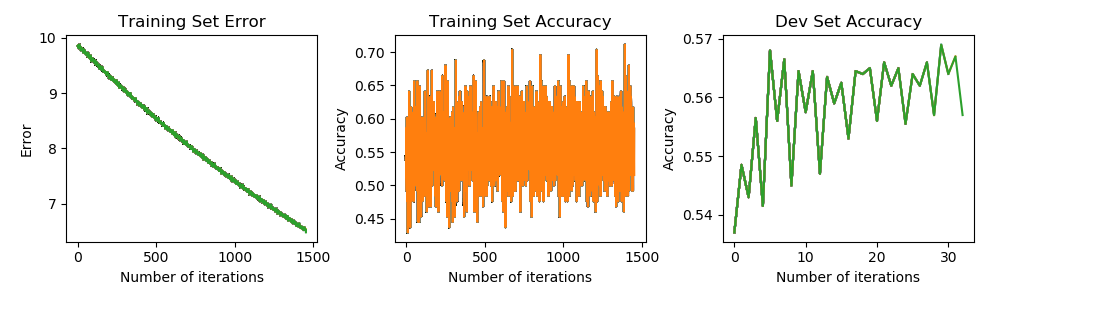

Training the model, epoch: 1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


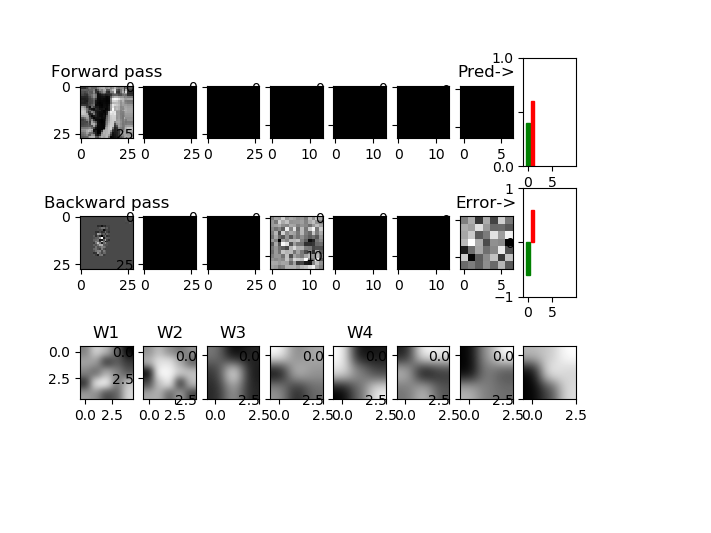

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.7719408751886556
a_conv2: 3.051810898350706
a_conv3: 3.1828371835833233
a_conv4: 4.800325237774106
a_flatten: 4.800325237774106
a_fc1: 4.843859173886059

 
Training set error: 9.855305966453962
Training set accuracy: 0.5390625
Accuracy on dev set: 0.537


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


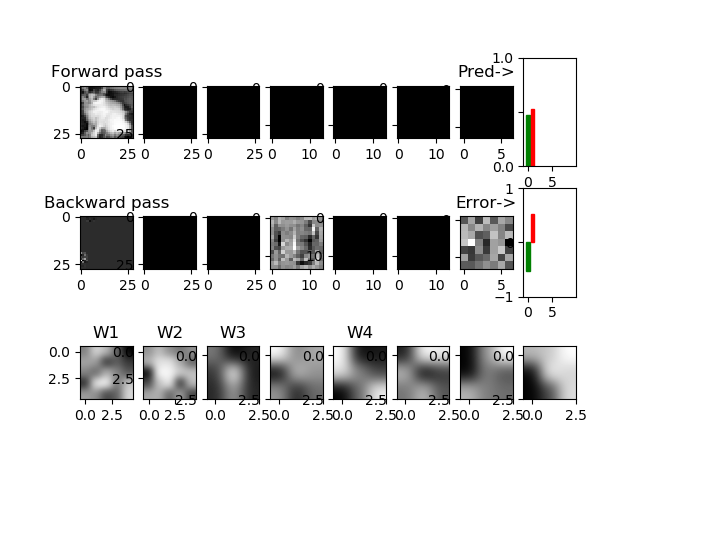

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.7717229800291341
a_conv2: 2.9719042170377263
a_conv3: 3.096353726860016
a_conv4: 4.64575393022628
a_flatten: 4.64575393022628
a_fc1: 5.090314965090078

 
Training set error: 9.736380240442246
Training set accuracy: 0.4765625
Accuracy on dev set: 0.5485


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


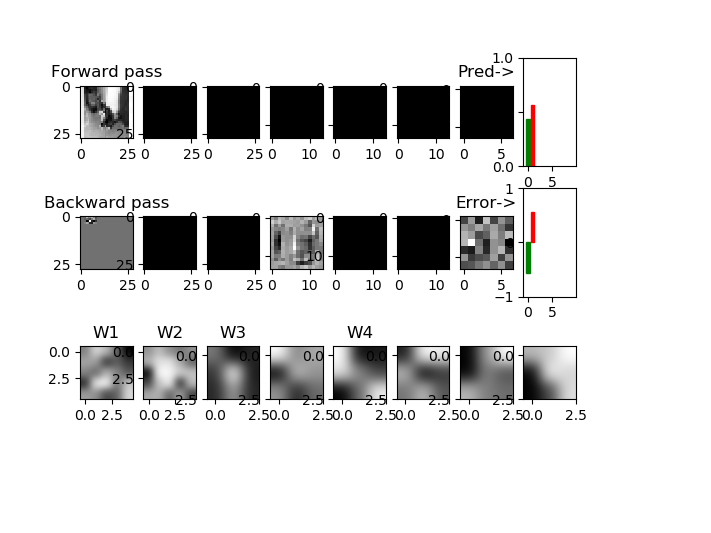

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.7544098214628674
a_conv2: 2.966307295111735
a_conv3: 3.331953745465294
a_conv4: 4.734271303179832
a_flatten: 4.734271303179832
a_fc1: 5.444436226327292

 
Training set error: 9.580809478139484
Training set accuracy: 0.59375
Accuracy on dev set: 0.543


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


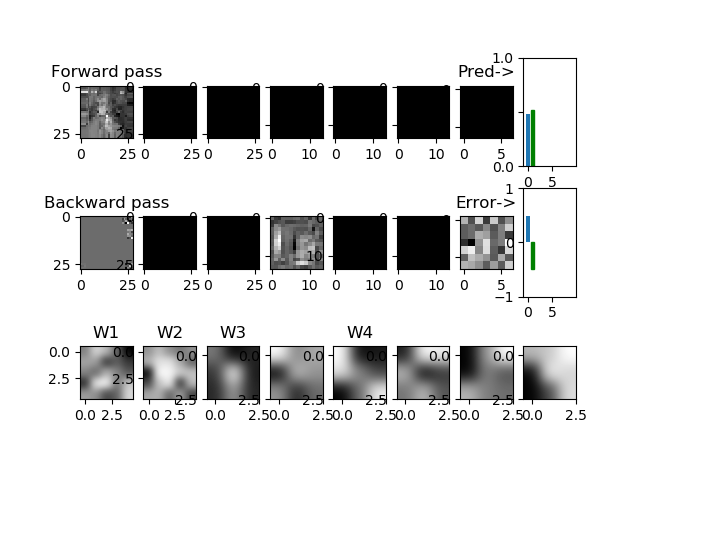

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8659859889460824
a_conv2: 2.920014926984669
a_conv3: 3.281306711371981
a_conv4: 4.789825476169565
a_flatten: 4.789825476169565
a_fc1: 4.209343497184602

 
Training set error: 9.454198853642232
Training set accuracy: 0.5703125
Accuracy on dev set: 0.5565
Training the model, epoch: 2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


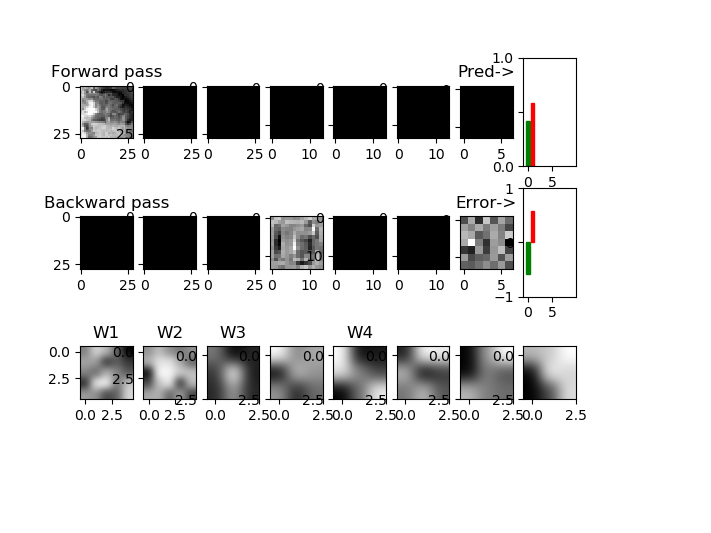

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.7794464107179202
a_conv2: 2.9849456741399125
a_conv3: 2.755750255391481
a_conv4: 4.205561834971308
a_flatten: 4.205561834971308
a_fc1: 4.214905337468039

 
Training set error: 9.368414999067936
Training set accuracy: 0.5703125
Accuracy on dev set: 0.5415


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


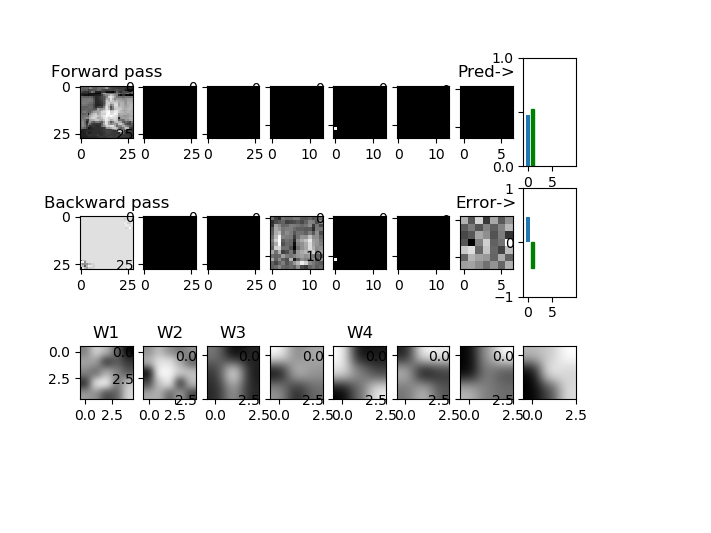

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.7805796021113481
a_conv2: 2.9210280715955554
a_conv3: 2.7239219262199303
a_conv4: 3.872820826328624
a_flatten: 3.872820826328624
a_fc1: 4.614010218738191

 
Training set error: 9.242683319659573
Training set accuracy: 0.5
Accuracy on dev set: 0.568


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


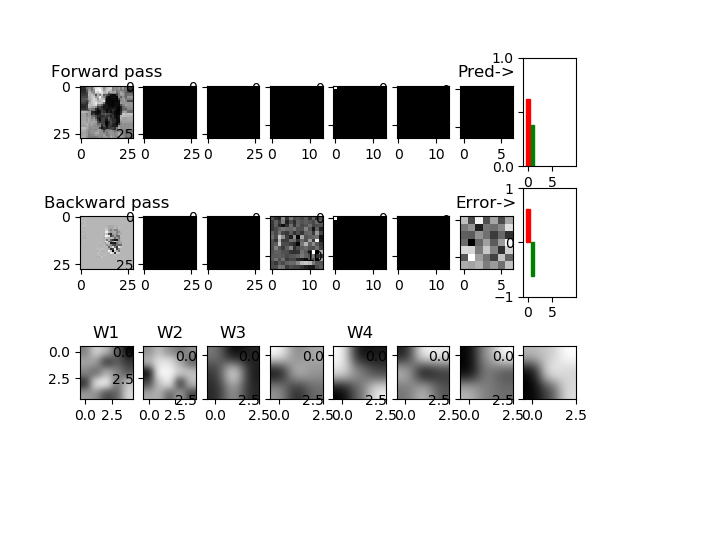

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.7642945484552668
a_conv2: 2.936286723111537
a_conv3: 3.0594354434818403
a_conv4: 4.1342167498734295
a_flatten: 4.1342167498734295
a_fc1: 5.037368202188761

 
Training set error: 9.097188536263262
Training set accuracy: 0.5859375
Accuracy on dev set: 0.556


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


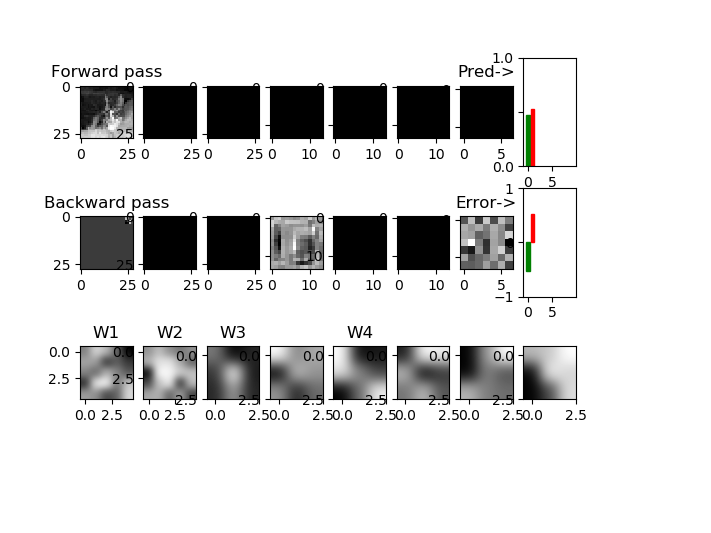

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8745091313634427
a_conv2: 2.908168875794442
a_conv3: 3.119563651547649
a_conv4: 4.395866380321635
a_flatten: 4.395866380321635
a_fc1: 4.043231106467706

 
Training set error: 8.975357705036332
Training set accuracy: 0.546875
Accuracy on dev set: 0.5665
Training the model, epoch: 3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


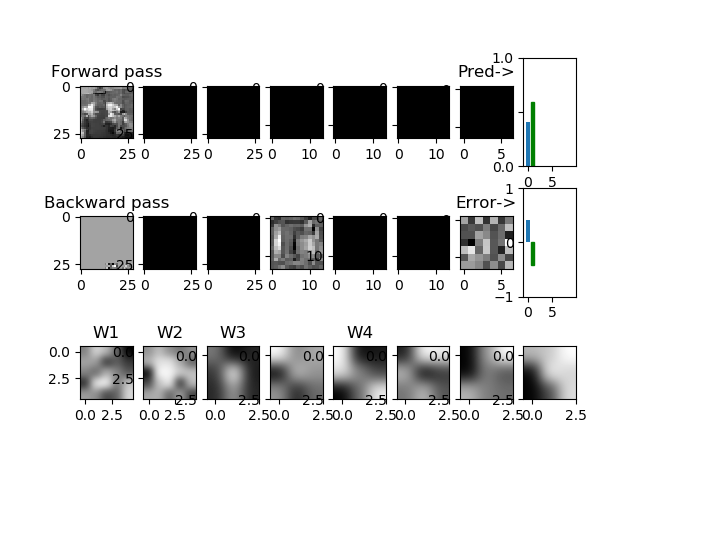

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.789024930730714
a_conv2: 2.9534203238839547
a_conv3: 2.640507066073269
a_conv4: 3.9495976884394923
a_flatten: 3.9495976884394923
a_fc1: 4.018601690481012

 
Training set error: 8.894963571132838
Training set accuracy: 0.5859375
Accuracy on dev set: 0.545


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


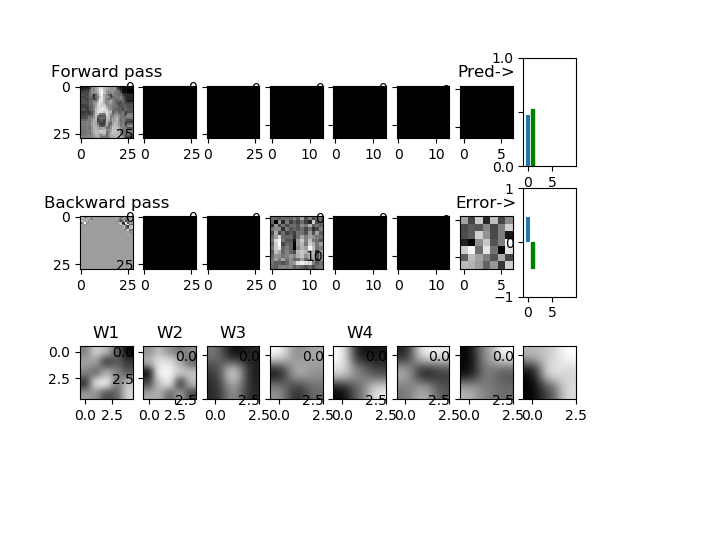

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.7911375796078215
a_conv2: 2.903352666439905
a_conv3: 2.607961151090882
a_conv4: 3.6844713154768596
a_flatten: 3.6844713154768596
a_fc1: 4.4239294721061935

 
Training set error: 8.775486390407139
Training set accuracy: 0.5234375
Accuracy on dev set: 0.5645


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


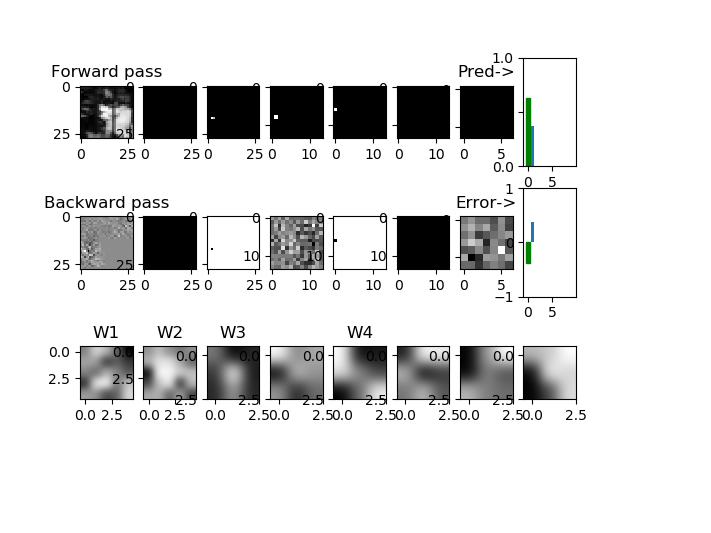

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.7724208808544306
a_conv2: 2.9149438688588774
a_conv3: 2.9609143530913338
a_conv4: 3.8918557782338374
a_flatten: 3.8918557782338374
a_fc1: 4.8816716443307815

 
Training set error: 8.640058660031432
Training set accuracy: 0.5703125
Accuracy on dev set: 0.5575


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


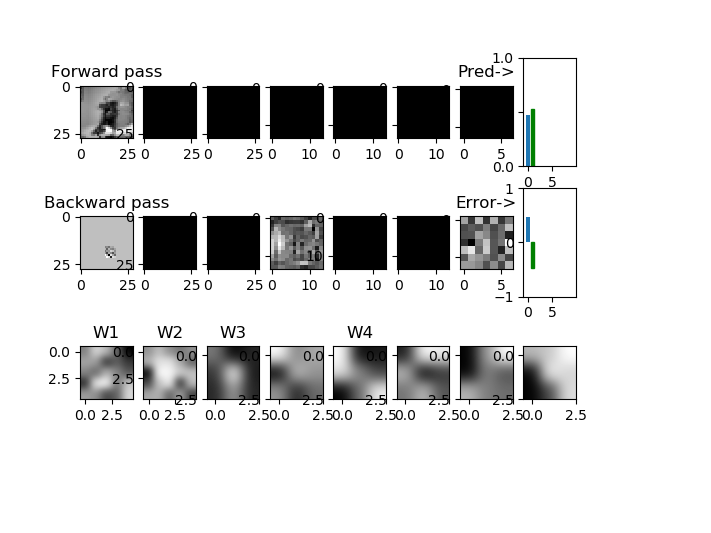

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8808929499220357
a_conv2: 2.886417889713447
a_conv3: 3.0200287503990535
a_conv4: 4.145652145064164
a_flatten: 4.145652145064164
a_fc1: 3.9434269077217783

 
Training set error: 8.523989205647851
Training set accuracy: 0.5625
Accuracy on dev set: 0.5645
Training the model, epoch: 4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


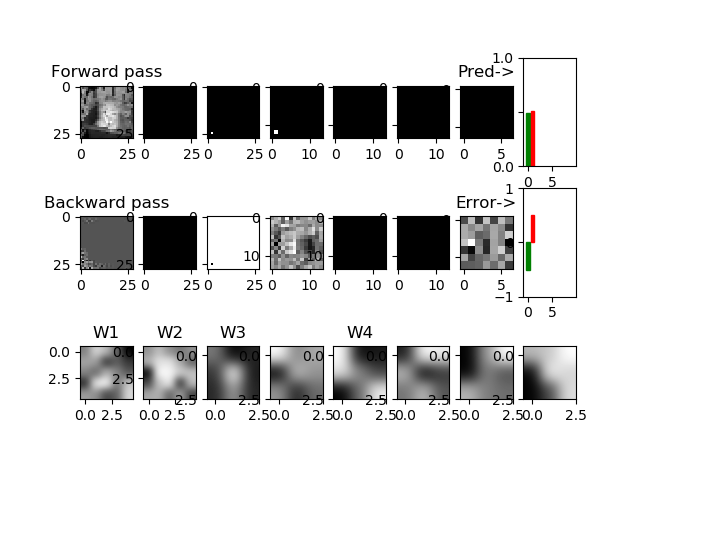

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.7979546892673857
a_conv2: 2.91457533087408
a_conv3: 2.5608452900194005
a_conv4: 3.731014377060814
a_flatten: 3.731014377060814
a_fc1: 3.8410587584187947

 
Training set error: 8.448697914507669
Training set accuracy: 0.5625
Accuracy on dev set: 0.547


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


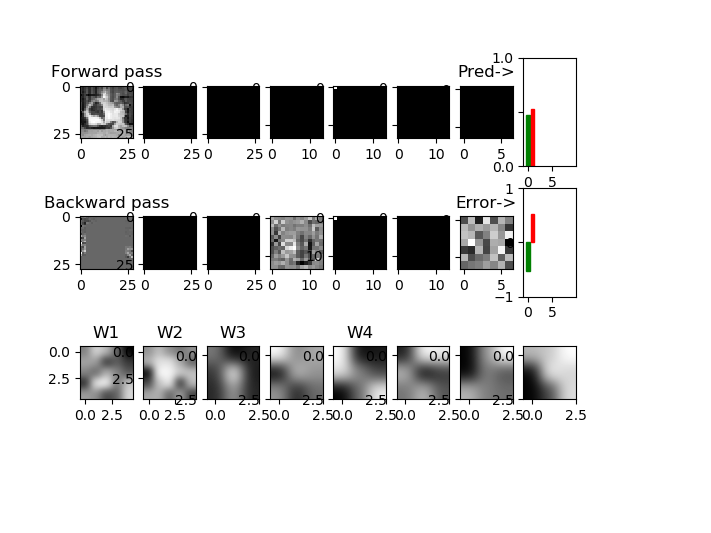

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8027460426759696
a_conv2: 2.8918298477274558
a_conv3: 2.5664716559045844
a_conv4: 3.5804668219870157
a_flatten: 3.5804668219870157
a_fc1: 4.377420489999681

 
Training set error: 8.334309064762673
Training set accuracy: 0.53125
Accuracy on dev set: 0.5635


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


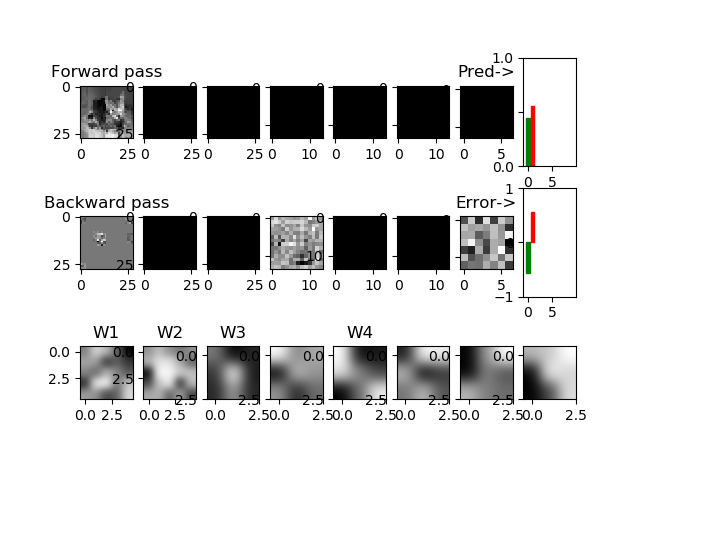

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.784055230694731
a_conv2: 2.9094899899091042
a_conv3: 2.945506579254637
a_conv4: 3.839099263380563
a_flatten: 3.839099263380563
a_fc1: 4.809824990612351

 
Training set error: 8.206794762490476
Training set accuracy: 0.5625
Accuracy on dev set: 0.559


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


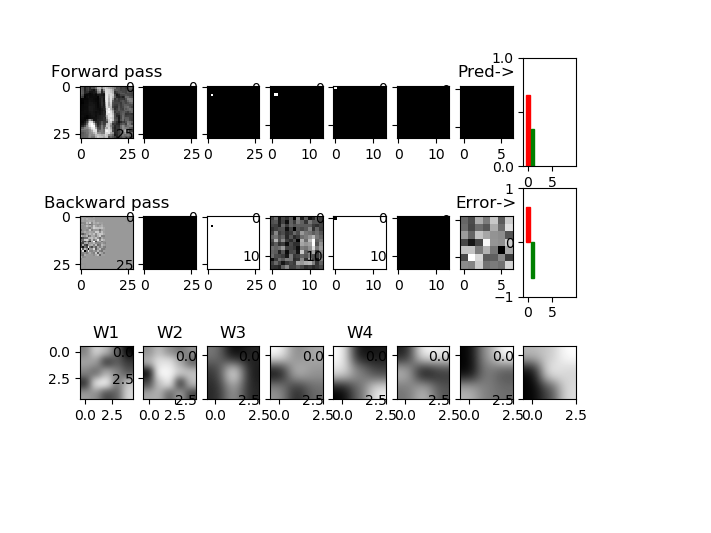

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8898134190861365
a_conv2: 2.87555324847942
a_conv3: 2.9618317717220624
a_conv4: 4.031739264456673
a_flatten: 4.031739264456673
a_fc1: 3.9349155129598037

 
Training set error: 8.098173308221389
Training set accuracy: 0.5703125
Accuracy on dev set: 0.5625
Training the model, epoch: 5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


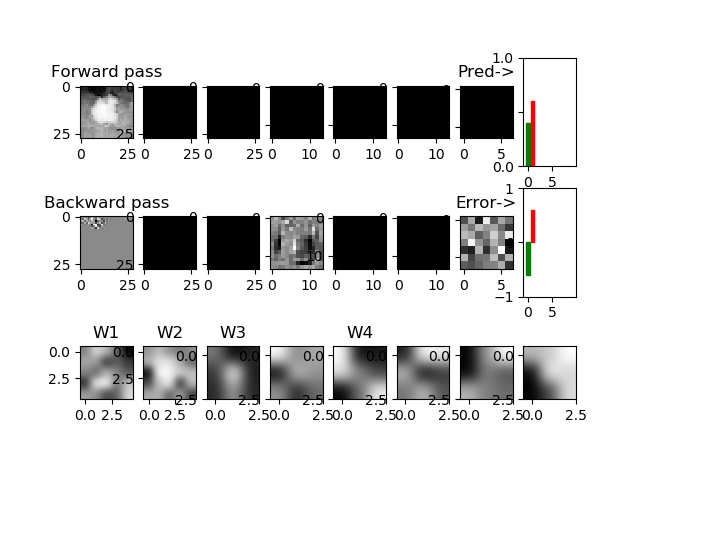

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8085733007279498
a_conv2: 2.8812123676608263
a_conv3: 2.518050281352255
a_conv4: 3.62266962385088
a_flatten: 3.62266962385088
a_fc1: 3.746404162307741

 
Training set error: 8.026081012832039
Training set accuracy: 0.546875
Accuracy on dev set: 0.553


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


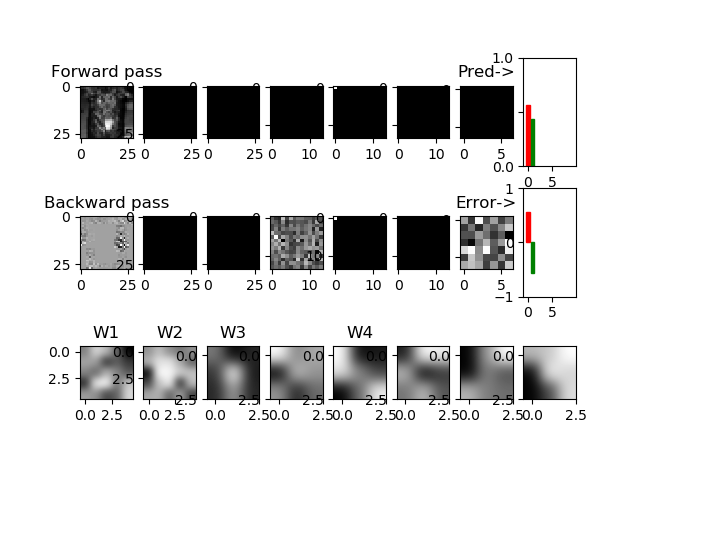

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8124838500353371
a_conv2: 2.871373081100689
a_conv3: 2.5552429119439926
a_conv4: 3.4711296734042123
a_flatten: 3.4711296734042123
a_fc1: 4.342922576916501

 
Training set error: 7.918152576142443
Training set accuracy: 0.53125
Accuracy on dev set: 0.5645


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


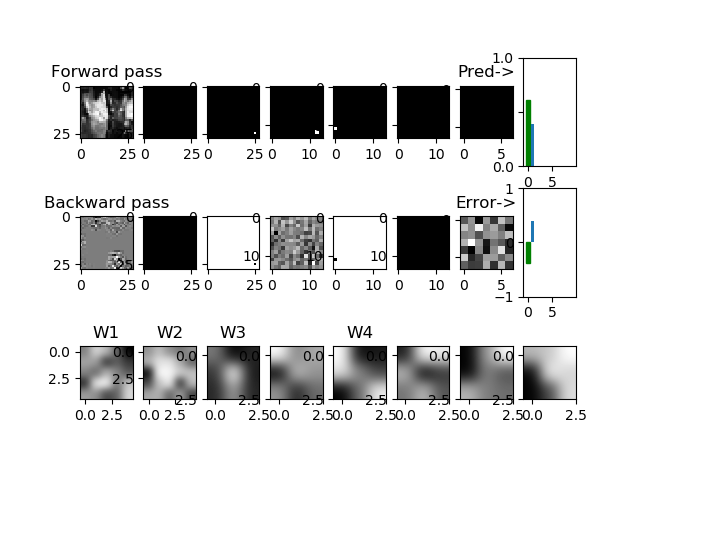

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.7920440632020178
a_conv2: 2.8830463079118624
a_conv3: 2.9128754183764793
a_conv4: 3.773332968088177
a_flatten: 3.773332968088177
a_fc1: 4.721516078595547

 
Training set error: 7.797677605383102
Training set accuracy: 0.5546875
Accuracy on dev set: 0.564


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


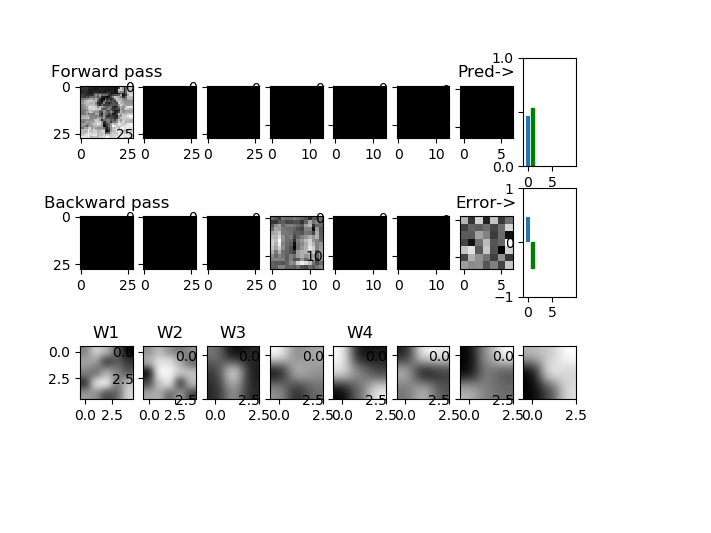

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8941251565349462
a_conv2: 2.8448778779942216
a_conv3: 2.8934258098470313
a_conv4: 3.908584961799415
a_flatten: 3.908584961799415
a_fc1: 3.9043336125566657

 
Training set error: 7.695351445084508
Training set accuracy: 0.5625
Accuracy on dev set: 0.565
Training the model, epoch: 6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


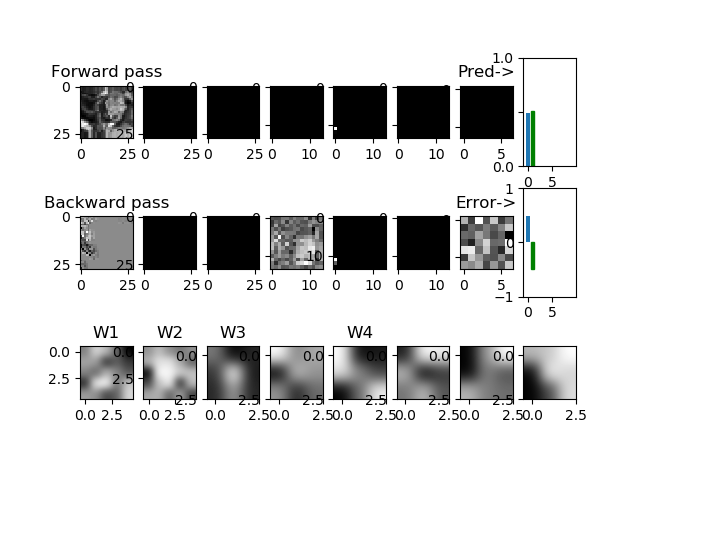

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8145041161048362
a_conv2: 2.8375927996043826
a_conv3: 2.5605400414080695
a_conv4: 3.537159241491783
a_flatten: 3.537159241491783
a_fc1: 3.7273366984172505

 
Training set error: 7.626944570016845
Training set accuracy: 0.5625
Accuracy on dev set: 0.556


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


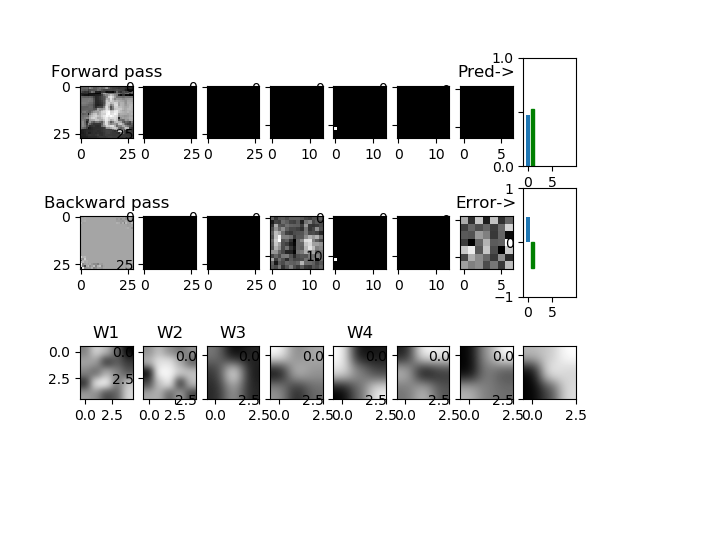

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8191964520541788
a_conv2: 2.8417056462415404
a_conv3: 2.558253658435311
a_conv4: 3.4377354305539973
a_flatten: 3.4377354305539973
a_fc1: 4.328341935536814

 
Training set error: 7.524224345783718
Training set accuracy: 0.5390625
Accuracy on dev set: 0.566


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


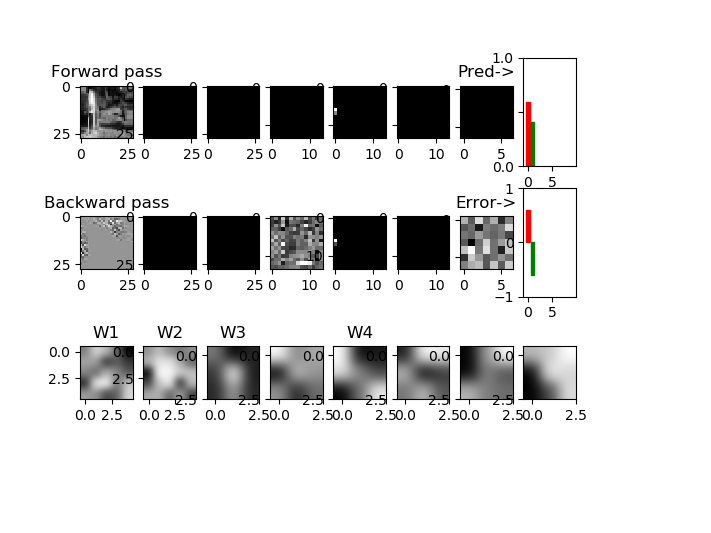

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.7993073059525407
a_conv2: 2.8556653483733148
a_conv3: 2.9000900843066937
a_conv4: 3.7661579504803386
a_flatten: 3.7661579504803386
a_fc1: 4.672530718496089

 
Training set error: 7.409891808579082
Training set accuracy: 0.5703125
Accuracy on dev set: 0.562


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


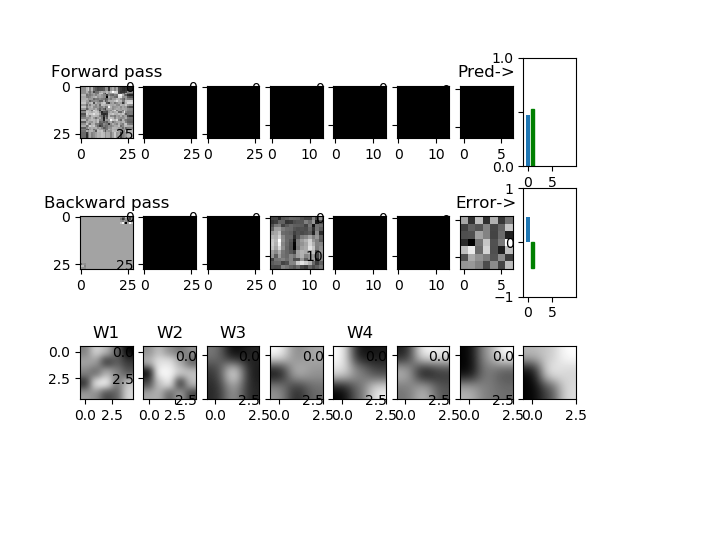

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8985894539132315
a_conv2: 2.8206530174786013
a_conv3: 2.86097892505434
a_conv4: 3.87723880374218
a_flatten: 3.87723880374218
a_fc1: 3.9429993354010073

 
Training set error: 7.314163409239232
Training set accuracy: 0.5625
Accuracy on dev set: 0.565
Training the model, epoch: 7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


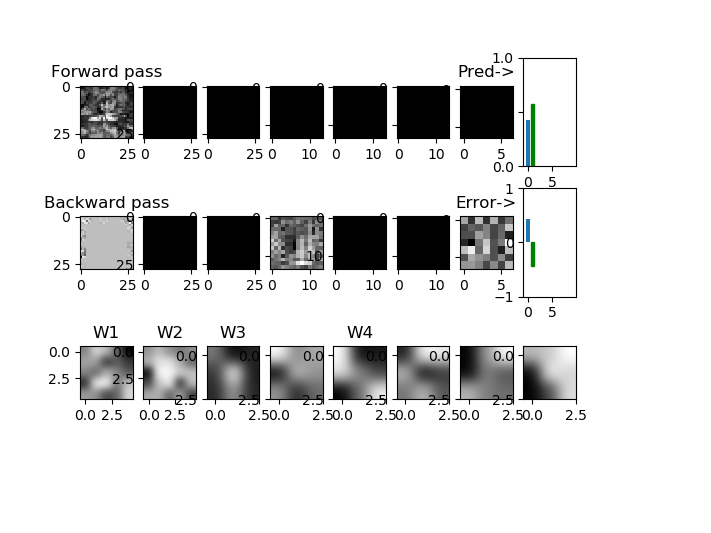

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8210445777148816
a_conv2: 2.795802246040788
a_conv3: 2.590422776220441
a_conv4: 3.563202202182074
a_flatten: 3.563202202182074
a_fc1: 3.727918594554855

 
Training set error: 7.249139978092886
Training set accuracy: 0.5703125
Accuracy on dev set: 0.5555


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


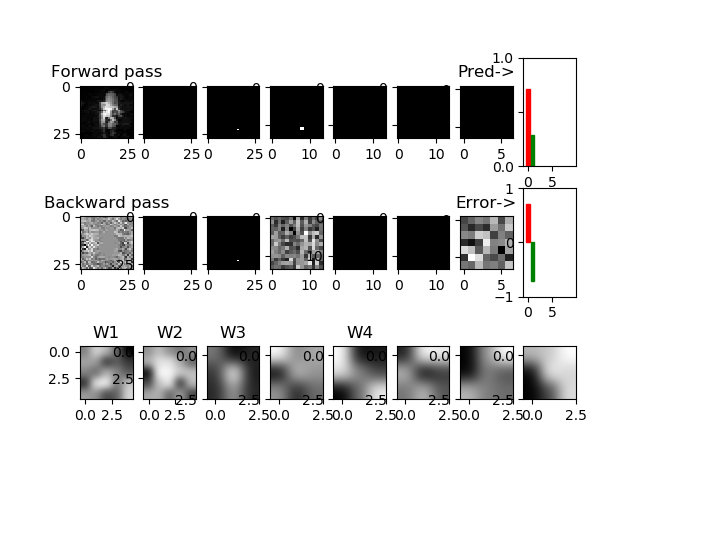

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.826466970208676
a_conv2: 2.8181755065891556
a_conv3: 2.5831172865277328
a_conv4: 3.4723385039129497
a_flatten: 3.4723385039129497
a_fc1: 4.3351769155357545

 
Training set error: 7.151963048390949
Training set accuracy: 0.5234375
Accuracy on dev set: 0.564


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


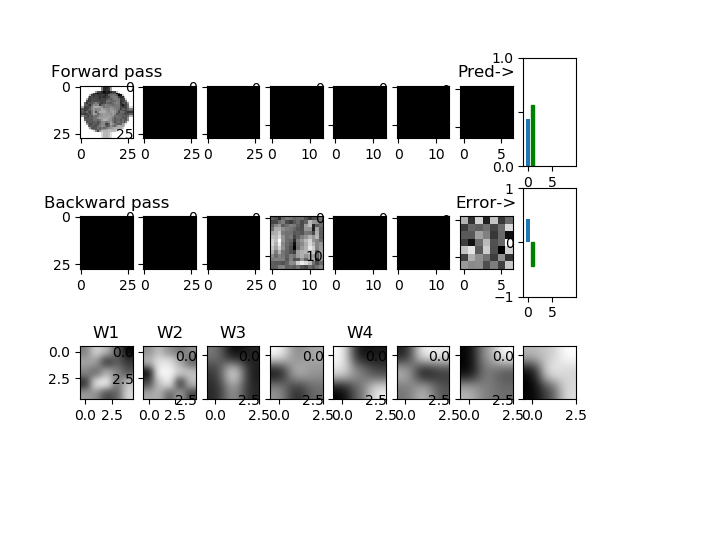

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8064741665485725
a_conv2: 2.8254203208217397
a_conv3: 2.884144498068034
a_conv4: 3.7597096208817735
a_flatten: 3.7597096208817735
a_fc1: 4.640179478561716

 
Training set error: 7.043283614592951
Training set accuracy: 0.5859375
Accuracy on dev set: 0.562


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


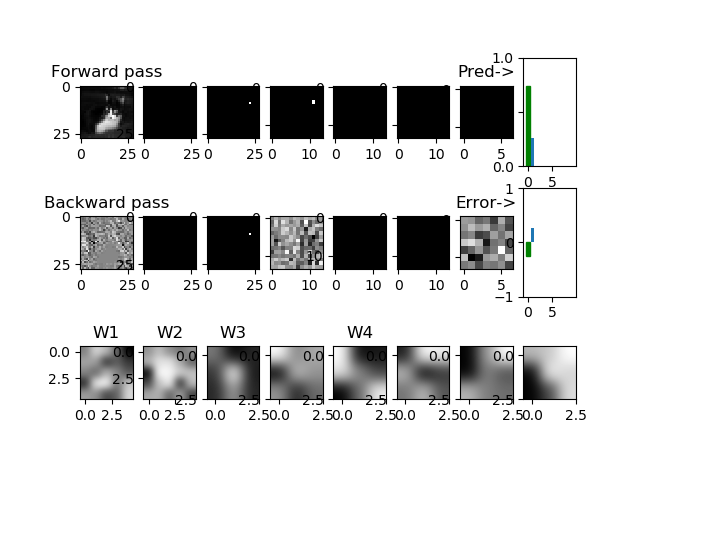

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.9034336067391797
a_conv2: 2.791898061279166
a_conv3: 2.8578168041312897
a_conv4: 3.8394675444366535
a_flatten: 3.8394675444366535
a_fc1: 3.9773107186060566

 
Training set error: 6.953923890318545
Training set accuracy: 0.5703125
Accuracy on dev set: 0.566
Training the model, epoch: 8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


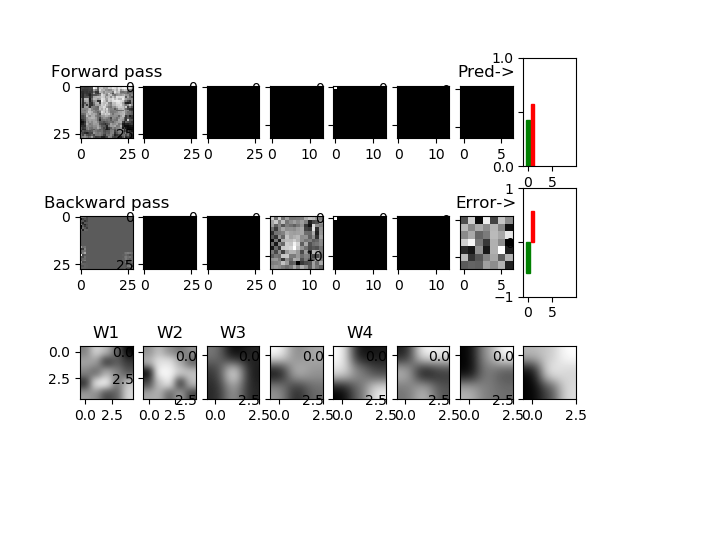

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8287501146252811
a_conv2: 2.7518433434056595
a_conv3: 2.5869028669045644
a_conv4: 3.575541143155343
a_flatten: 3.575541143155343
a_fc1: 3.734071740906236

 
Training set error: 6.892220539859304
Training set accuracy: 0.5703125
Accuracy on dev set: 0.557


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


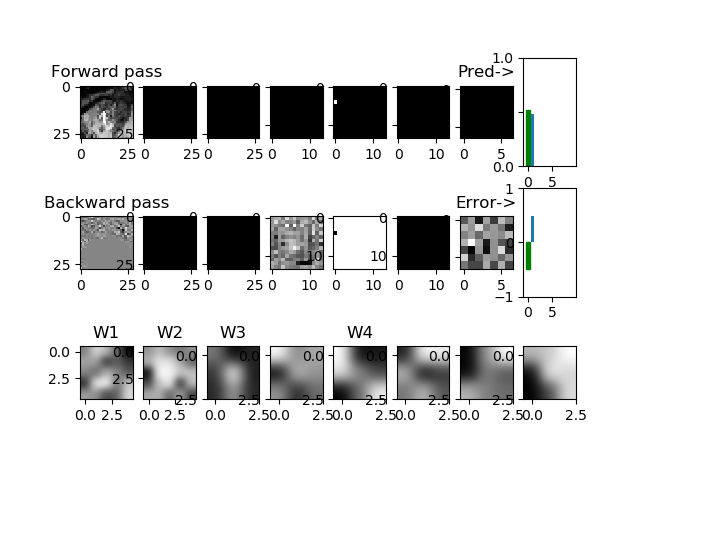

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8338330601557055
a_conv2: 2.7890813553964846
a_conv3: 2.6004227135362603
a_conv4: 3.4968243343712366
a_flatten: 3.4968243343712366
a_fc1: 4.329633510022967

 
Training set error: 6.800217446728789
Training set accuracy: 0.5
Accuracy on dev set: 0.569


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


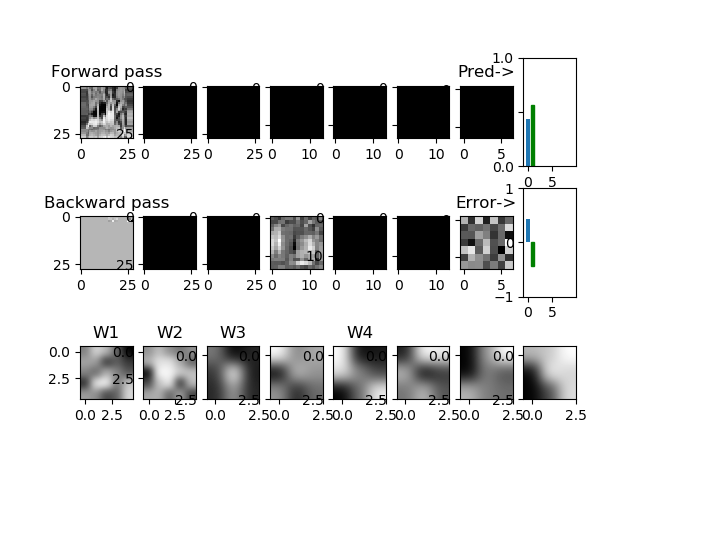

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.811693390899616
a_conv2: 2.7904564613584695
a_conv3: 2.882280411494902
a_conv4: 3.7764864441579356
a_flatten: 3.7764864441579356
a_fc1: 4.640995384674065

 
Training set error: 6.696231952422727
Training set accuracy: 0.5703125
Accuracy on dev set: 0.564


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


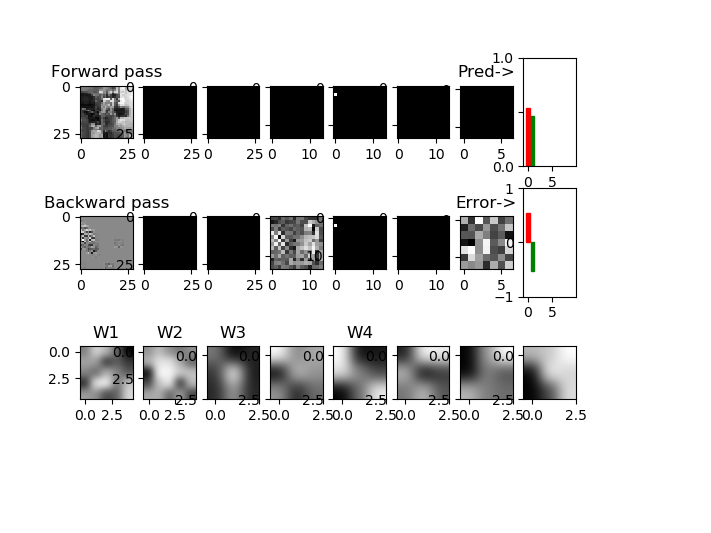

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.9060349861823168
a_conv2: 2.7620557545074975
a_conv3: 2.902435201550843
a_conv4: 3.8760805114212595
a_flatten: 3.8760805114212595
a_fc1: 4.059421729462269

 
Training set error: 6.61285361754297
Training set accuracy: 0.5625
Accuracy on dev set: 0.567
Training the model, epoch: 9


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


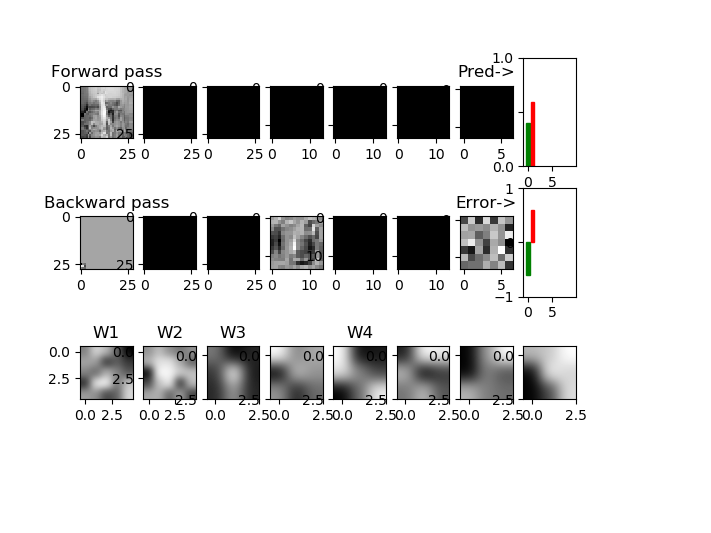

MAX ACTIVATION OF LAYERS: 
a_conv1: 0.8331827793349104
a_conv2: 2.71342126208475
a_conv3: 2.584265558121201
a_conv4: 3.6075919080353867
a_flatten: 3.6075919080353867
a_fc1: 3.7546995616920102

 
Training set error: 6.555497128307592
Training set accuracy: 0.5703125
Accuracy on dev set: 0.557


In [ ]:
parameters =train_model(x_trainT,y_trainT,x_devT,y_devT,
                        num_epochs=50,batch_size=128,lambd=2,learning_rate=1e-3)

### Conclusiones
Por motivos de tiempo apenas hemos podido realizar 7 epochs, sin embargo nos alegra ver que el accuracy en el eval es de 0.57, si comparamos con la métrica de la parte 1, (0.77), existe una diferencia de 0.2, recalcando que el número de epochs es muy diferente 50 en la parte 1 y apenas 7 con nuestro algoritmo.

Aun falta mucho por hacer, en primer lugar, disminuir el código de visualizacion, permitiendo al investigador mostrar solo lo relativamente importante, como se lo especifica en el verbose del toolkit en la parte 1 que nos muestra ya el cálculo final en cada epoch, como vemos acá tenemos un montón de datos que relentizan un 40% del procesamiento, abismal...!, pero muy bueno para la finalidad de aprendizaje.

En este código podemos ver de una manera más clara como funciona el modelo convolucional,  a más de, que es un código  genérico y no reduce la matriz de evaluación a un método binario, es decir, que este método utiliza los 10 valores de comparación desperdiciando mucho tiempo, habrá que optimizar este algoritmo para que sea mas flexible como en el caso del toolkit en keras que permite especificar cuando se trata de un problema binario.

Por último, no menos importante, utilizar gpus para mejorar el procesamiento.

Como aprendizaje hasta el momento muy satisfecho, es el primer paso, y a por más!.

### Referencias
- Convolutional Neural Network https://github.com/mukul-rathi/deep-learning-tutorials/blob/master/ConvolutionalNeuralNet/convnet.ipynb
- Deep Learning with Keras — Classifying Cats and Dogs (Part 1) https://medium.com/@ferhat00/deep-learning-with-keras-classifying-cats-and-dogs-part-1-982067594856
